<IPython.core.display.Javascript object>


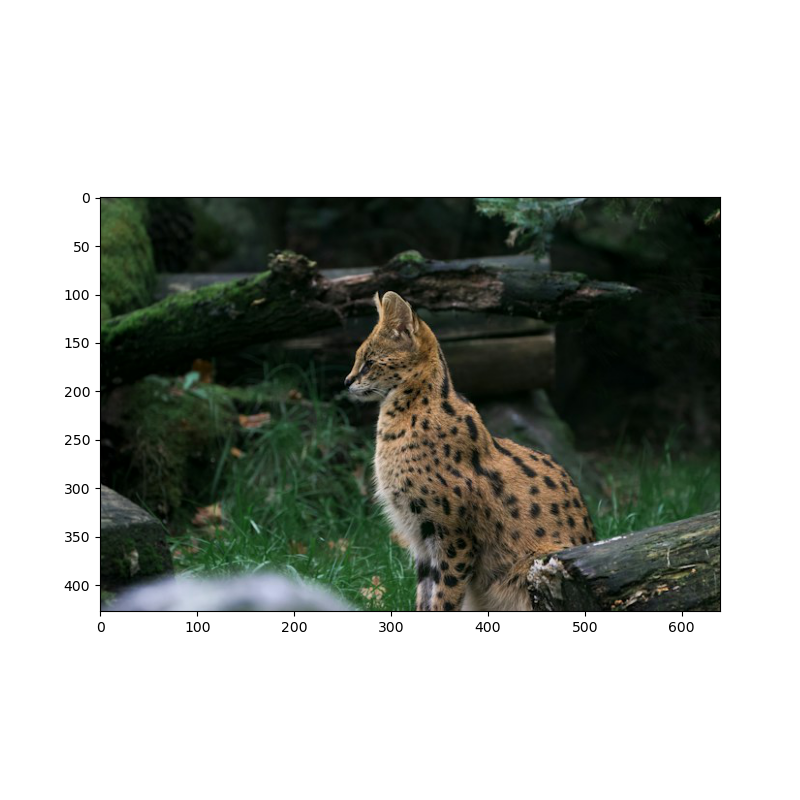

In [1]:
%matplotlib notebook
import numpy as np
from numpy import cos, sin
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from ipywidgets import interact, fixed

img = plt.imread('jaguatirica.png').astype(float)
plt.figure(figsize=[8,8])
plt.imshow(img)

In [28]:
def get_similarity_matrix(tr, tc, angle, s):
    
    ''' Return the similarity matrix '''
    
    Ts = np.array([[s*cos(angle), -s*sin(angle), tr],
                   [s*sin(angle),  s*cos(angle), tc],
                   [0.          ,            0., 1.]])
    
    return Ts

def get_similarity_transform_matrix_ref(tr, tc, angle, s, reference_point):
    
    ''' Return the similarity matrix given a reference point '''
    
    pr, pc = reference_point
    # Transfer the reference point to the origin
    Tt1 = get_similarity_matrix(-pr, -pc, 0., 1.)
    Ts = get_similarity_matrix(tr, tc, angle, s)
    # Transfer back
    Tt2 = get_similarity_matrix(pr, pc, 0., 1.)
        
    T = Tt2@Ts@Tt1
    
    return T

def transform_point(point, T):
    
    ''' Apply the transformation given a point '''
   
    # Create point as homogeneous coordinates and as column vector
    point_h = np.array([[point[0], point[1], 1]]).transpose()
    
    point_transf = T@point_h
    
    # point_transf = [np.array(point_transf[0,0], point_transf[1,1]])
    point_transf = point_transf[:2,0]
    
    return point_transf


def bilinear_interpol(img, point):
    
    ''' Return the intensity ''' 
    
    row_int = int(point[0])
    col_int = int(point[1])
    row_frac = point[0]-row_int
    col_frac = point[1]-col_int
    I00 = img[row_int, col_int]
    I01 = img[row_int, col_int+1]
    I10 = img[row_int+1, col_int]
    I11 = img[row_int+1, col_int+1]
    
    val = (I00*(1-row_frac)*(1-col_frac) + I01*(1-row_frac)*col_frac + 
           I10*row_frac*(1-col_frac) + I11*row_frac*col_frac) 
    
    return val    

def transform_image_interpol(img, T, out_img_corners):
    
    ''' Transform the image using bilinear interpolation'''
    
    # Point superior left e inferior right
    # define the output area
    nr, nc = img.shape
    
    out_img_upper_left = out_img_corners[0]
    out_img_bottom_right = out_img_corners[1]
    
    # Add line and col in the image
    img_pad = np.pad(img, pad_width=(0,1), mode='reflect')
    
    img_width = out_img_bottom_right[1] - out_img_upper_left[1]
    img_height  = out_img_bottom_right[0] - out_img_upper_left[0]
    T_inv = np.linalg.inv(T)
    
    out_img = np.zeros((img_height, img_width))
    
    # row, col - pixel in the output image - r' vector
    # new_row_coord, new_col_coord - coord in space (x,y)
    # row_coord, col_coord - coord in space(x,y) input img - r vector
    for row in range(img_height):
        
        # transform pixel to coord x,y
        out_row_coord = row + out_img_upper_left[0]
        for col in range(img_width):
            out_col_coord = col + out_img_upper_left[1]
            out_p = (out_row_coord, out_col_coord)
            
            in_p = transform_point(out_p , T_inv)
            
            in_row_coord, in_col_coord = in_p
            
            # Verify if the point is inside the image
            if in_row_coord>=0 and in_row_coord < nr \
            and in_col_coord>=0 and in_col_coord < nc:
                in_row_coord = int(in_row_coord)
                in_col_coord = int(in_col_coord)
                val = bilinear_interpol(img_pad, in_p)
                out_img[row, col] = val
            
    return out_img

def transform_multichannel_image_interpol(img, Ts, out_img_corners):
    
    ''' Transform a multichannel image using bilinear interpolation' '''
    
    img_height, img_width, img_channels = img.shape
    
    out_img = np.zeros((img_height, img_width, img_channels))
    # transform each channel
    for channel in range(img_channels):
        out_img[:,:, channel] = transform_image_interpol(img[:,:,channel], Ts, out_img_corners)
        
    return out_img  

In [33]:
def calculate_image_angles(img, angle):
    
    ''' Calculate image transfomations as requested in class '''
    
    img_height, img_width, img_channels = img.shape
    out_img_corners = ((0,0), (img_height, img_width))
    reference_point = (img_height//2, img_width//2)
    
    for i in range(16):
        Ts = get_similarity_transform_matrix_ref(0, 0, i*angle, 1., reference_point) 
        out_img = transform_multichannel_image_interpol(img, Ts, out_img_corners)
        plt.imsave(f"img_transf_angle_{i*angle}.png", out_img[img_height//4 : 3 * img_height//4 , img_width//4: 3 * img_width//4, :])   


def calculate_image_transformations(img, transformations):
    
    ''' Calculate image transfomations given a list of transformations '''
    
    img_height, img_width, img_channels = img.shape
    out_img_corners = ((0,0), (img_height, img_width))
    reference_point = (img_height//2, img_width//2)
    
    for transf in transformations:
        Ts = get_similarity_transform_matrix_ref(transf[0], transf[1], transf[2], transf[3], reference_point)
        out_img = transform_multichannel_image_interpol(img, Ts, out_img_corners)
        plt.imsave(f"img_transf_{transf[4]}.png", out_img[img_height//4 : 3 * img_height//4 , img_width//4: 3 * img_width//4, :])       

In [36]:
transf = [(100, 0, 0, 1.,'rotation_r_100'), 
          (-100, 0, 0, 1., 'rotation_r_-100'),
          (0, 100, 0, 1., 'rotation_c_100'),
          (0, -100, 0, 1., 'rotation_c_-100'),
          (0, 0, 0, 4., 'scale_4x'),
          (0, 0, 0, 2., 'scale_2x'),
          (0, 0, 0, .75, 'scale_075x'),
          (0, 0, 0, .5, 'scale_05x')]

img_height, img_width, img_channels = img.shape

calculate_image_transformations(img, transf)
calculate_image_angles(img, np.pi/8)
plt.imsave(f"img_original_center.png", img[img_height//4 : 3 * img_height//4 , img_width//4: 3 * img_width//4, :])  